# Bayesian inference: Modeling

## Table of Content:

- IV [Simple Bayesian Modeling](#IV.-Simple-Bayesian-Modeling)
    * IV.1 [The model](#IV.1-The-model)
    * IV.2 [The prior](#IV.-2-The-prior): Conjugate, empirical, flat and non informative priors
    * IV.3 [Implementation](#IV.3-Implementation)
- V Bayesian modeling with Monte Carlo Markov Chains (MCMC): See [Bayes_MCMC.ipynb](Bayes_MCMC.ipynb)
- X [References](#XX-References:)

## IV. Simple Bayesian Modeling

We'll start with the classic model fitting problem: **Fitting a line to data**.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

For the sake of illustration, we will generate a fake data set. 

<Container object of 3 artists>

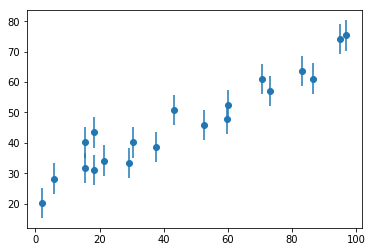

In [2]:
# Function that generates points following a linear trend. 
def make_data(intercept, slope, N=20, dy=5, rseed=42):
    '''
    Parameters:
    -----------
    intercept, slope: parameters of the linear model
    dy: width of normally distributed data points around the "true line"
    rseed: Seed of the random number generator (fixed for the sake of discussion)
    Output:
    -------
    x, y, sig_y 
    '''
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N)
    return x, y, dy * np.ones_like(x)

theta_true = [25, 0.5]
x, y, dy = make_data(theta_true[0], theta_true[1])  # could also be make_data(*theta_true)
plt.errorbar(x, y, dy, fmt='o')

### IV.1 The model

Next we need to specify a model. We're fitting a straight line to data, so we'll need a slope and an intercept; i.e.

$$
y_M(x) = \theta_0 + \theta_1\,x 
$$

where our parameter vector might be 

$$
\boldsymbol{\theta} = [\theta_0, \theta_1]
$$

But this is only half the picture: what we mean by a "model" in a Bayesian sense is not only the expected value $<y(x;\boldsymbol{\theta})>$, but a **probability distribution** for our data.
That is, we need an expression to compute the likelihood $P(D\mid\theta)$ for our data as a function of the parameters $\boldsymbol{\theta}$.

You may remember from the [previous lecture](../Lecture_6/Lecture_6.ipynb) that the likelihood for n (independent) points ($y_i$) drawn from a normal distribution:
$$
y_i \sim N(y_M(x_i; \boldsymbol{\theta}), \sigma)
$$
the likelihood is the product of the probabilities for each single data point, namely:

$$
p(y_i\,\mid\,\boldsymbol{\theta} ) = \frac{1}{\sigma \sqrt{2\,\pi}} \, \exp\left[-0.5 \left (\frac{y_i - y_M(x_i; \boldsymbol{\theta})}{\sigma} \right)^2\right] 
$$

Hence (generalised to heterosedastic errors):

$$
L \equiv P(D\mid\boldsymbol{\theta}) = \prod_{i=1}^N P(x_i,y_i\mid\boldsymbol{\theta})
$$

$$
P(D\mid\boldsymbol{\theta}) =  \prod_{i=1}^{N} \frac{1}{\sqrt{2\,\pi \sigma_i^2}} \, \exp\left[\left (\frac{ -(y_i - (\theta_0+\theta_1\,x_i))^2}{2\,\sigma_i^2} \right)\right]
$$

Or, written in terms of log-likelihood:

$$
\ln(P(D\mid\boldsymbol{\theta})) \, = -\frac{1}{2}\,\sum_{i=1}^{N} \left (\ln(2\pi\sigma_i^2) + \frac{ (y_i - (\theta_0+\theta_1\,x_i))^2}{\sigma_i^2} \right) 
$$

We can now write a function that computes the log-likelihood given a parameter vector $\boldsymbol{\theta}$, an array of errors $\sigma_i$, and an array of $x$ and $y$ values.


In [3]:
def ln_likelihood(theta, x, y, dy):
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) + (y - y_model) ** 2 / dy ** 2)

The frequentist approach would be to search for the maximum of the likelihood. The Bayesian approach is more comprehensive. It is not a matter of finding the most likely estimator of $\theta$ but of deriving the **full posterior probability** $P(\boldsymbol{\theta}~\mid~D)$. For that purpose we need to set a prior ... 

### IV. 2 The prior

#### IV.2.1 Conjugate priors

In the early days of Bayesian analysis, people were considering [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior). A *conjugate prior* is a prior which, due to its mathematical relation to the likelihood, makes the result analytically computable. Those priors are rarely defensible on any grounds other than computational convenience, and so this is **almost never a good choice**.

#### IV.2.2 Empirical priors

Empirical Priors are priors which are actually posteriors from previous studies of the same phenomenon. For example, it's common in Supernova cosmology studies to use the WMAP results as a prior: that is, we actually plug-in a *real result* and use our new data to improve on that. This situation is where Bayesian approaches really shine.

For our linear fit, you might imagine that our $x, y$ data is a more accurate version of a previous experiment, where we've found that the intercept is $\theta_0 = 50 \pm 30$ and the slope is $\theta_1 = 1.0 \pm 0.5$.
In this case, we would encode this prior knowledge in the prior distribution itself.

#### IV.2.3 Flat Priors

If you don't have an empirical prior, you might be tempted to simply use a *flat prior* – i.e. a prior that is constant between two reasonable limits (i.e. equal probability slopes from -1000 to +1000).

The problem is that flat priors are not always non-informative! For example, a flat prior on the slope will effectively give a higher weight to larger slopes.
We can see this straightforwardly by plotting regularly-spaced slopes between 0 and 20:

[-1, 1, -1, 1]

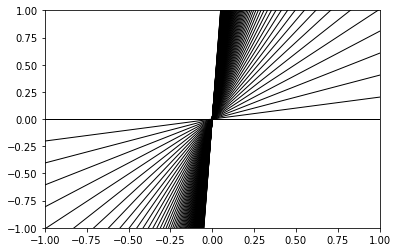

In [4]:
xx = np.linspace(-1, 1)
for slope in np.linspace(0, 20, 100):
    plt.plot(xx, slope * xx, '-k', linewidth=1)
plt.axis([-1, 1, -1, 1], aspect='equal')

The density of the lines is a proxy for the probability of those slopes with a flat prior.
This is an important point to realize: **flat priors are not necessarily minimally informative**.

#### IV.2.4 Non-informative Priors

What we *really* want in cases where no empirical prior is available is a **non-informative prior**. Among other things, such a prior should not depend on the units of the data.
Perhaps the most principled approach to choosing non-informative priors was the *principle of maximum entropy* advocated by Jaynes ([book](http://omega.albany.edu:8008/JaynesBook.html)).

Similar in spirit is the commonly-used [Jeffreys Prior](https://en.wikipedia.org/wiki/Jeffreys_prior), which in many cases of interest amounts to a "scale invariant" prior: a flat prior on the logarithm of the parameter.

In the case of the linear slope, we often want a prior which does not artificially over-weight large slopes: there are a couple possible approaches to this (see http://arxiv.org/abs/1411.5018 for some discussion). For our situation, we might use a flat prior on the angle the line makes with the x-axis, which gives

$$
P(\theta_1) \propto (1 + \theta_1^2)^{-3/2}
$$

For lack of a better term, we can call this a "symmetric prior" on the slope. Indeed, it is the same whether we are fitting $y = \theta_1 \, x + \theta_0$ or $x = \theta_1^\prime\,y + \theta_0^\prime$.

## IV.3 Implementation

Let's define two python functions to compute the options for our prior: we'll use both a (log) flat prior and a (log) symmetric prior.
In general, we need not worry about the normalization of the prior or the likelihood, which makes our lives easier:

In [8]:
def ln_flat_prior(theta):
    '''
    theta = shape(2) array containing the [intercept, slope] = [theta_0, theta_1]
    '''
    if np.abs(theta[1]) < 1000:
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def ln_symmetric_prior(theta):
    '''
    theta = shape(2) array containing the [intercept, slope] = [theta_0, theta_1]
    '''
    if np.abs(theta[1]) < 1000:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)

With these defined, we now have what we need to compute the log posterior as a function of the model parameters.
You might be tempted to maximize this posterior in the same way that we did with the likelihood above. However, the proper Bayesian approach is not just a matter of getting the maximum of the posterior of our parameters but aims at getting the (possibly marginalized) posterior probability for our parameters. 

Remember that the posterior probability on the parameters is the product of the likelihood and of the prior. Hence the log of the posterior is the sum of the of the log of these two quantities. For the simple case above, we can explicitly evaluate the log probability on a grid for the 2 parameters of our model. 

#### Exercise:

1. Using matplotlib, plot the posterior probability distribution for the slope and intercept, once for each prior. I would suggest using ``plt.contourf()`` or ``plt.pcolor()``. How different are the distributions?

2. Modify the dataset – how do the results change if you have very few data points or very large errors?

3. If you finish this quickly, try adding 1-sigma and 2-sigma contours to your plot, keeping in mind that the probabilities are not normalized! You can add them to your plot with ``plt.contour()``.

In [20]:
# Use the cells below to evaluate the log likelihood for each of the two priors above
def ln_P1(x, y, dy, slope_limits=[0.3, 0.7], intercept_limits=[15,35], norm=True):
    '''
    Description: Function that returns posterior proba. for flat prior on slope
    ------------
    Parameters:
    -----------
    x, y, dy: Data 
    slope_limits: list
        Range over which we calculate the slope
    intercept_limits: list
        range over which I calculate the intercept
    norm: boolean
        If true, returns the posterior probabilit ; if False returns ln(P)
    Returns:
    --------
    ln(P), slope_2D, intercept: np.arrays(shape=(100,100)
        3 arrays containing ln(posterior), slope (2D meshgrid), intercept(2D meshgrid)
    '''
    slope_vals = np.linspace(slope_limits[0], slope_limits[1], 100)
    intercept_vals = np.linspace(intercept_limits[0], intercept_limits[1], 100)
    slope_2D, intercept_2D = np.meshgrid(slope_vals, intercept_vals)
    
    ln_P = np.zeros(shape=(100, 100))
    P = np.zeros(shape=(100, 100))
    for i, slope in enumerate(slope_vals):
        for j, intercept in enumerate(intercept_vals):
            theta = [intercept, slope]
            ln_P[i, j] = ln_likelihood(theta, x, y, dy) + ln_flat_prior(theta)
    if norm:
        P = np.e**ln_P / np.sum(np.e**(ln_P)) 
        return P, slope_2D, intercept_2D
    return ln_P, slope_2D, intercept_2D

In [23]:
def ln_P2(x, y, dy, slope_limits=[0.3, 0.7], intercept_limits=[15,35], norm=True):
    '''
    x, y, dy: Data 
    slope_limits: list
        Range over which we calculate the slope
    intercept_limits: list
        range over which I calculate the intercept
    '''
    slope_vals = np.linspace(slope_limits[0], slope_limits[1], 100)
    intercept_vals = np.linspace(intercept_limits[0], intercept_limits[1], 100)
    slope_2D, intercept_2D = np.meshgrid(slope_vals, intercept_vals)
    
    ln_P = np.zeros(shape=(100, 100))
    P = np.zeros(shape=(100, 100))
    for i, slope in enumerate(slope_vals):
        for j, intercept in enumerate(intercept_vals):
            theta = [intercept, slope]
            ln_P[i, j] = ln_likelihood(theta, x, y, dy) + ln_symmetric_prior(theta)
    if norm:
        P = np.e**ln_P / np.sum(np.e**(ln_P)) 
        return P, slope_2D, intercept_2D
    return ln_P, slope_2D, intercept_2D

In [49]:
x, y, dy = make_data(theta_true[0], theta_true[1], N=20) 

<Container object of 3 artists>

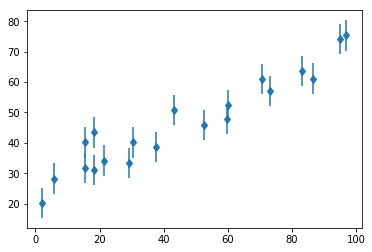

In [50]:
plt.errorbar(x, y, dy, ls='', marker='d')

Text(0,0.5,'intercept')

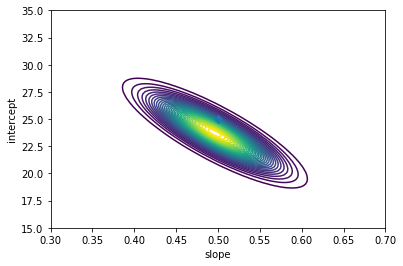

In [51]:
P1, X, Y = ln_P1(x, y, dy, norm=True)
plt.contour(X, Y, P1, 40)
plt.plot(0.5, 25, marker='D')
plt.xlabel('slope')
plt.ylabel('intercept')

Text(0,0.5,'intercept')

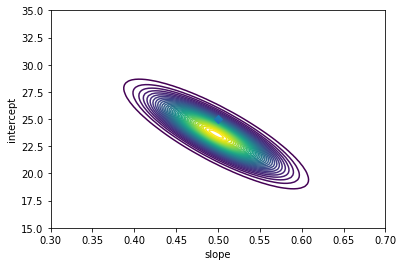

In [52]:
P2, X, Y = ln_P2(x, y, dy, norm=True)
plt.contour(X, Y, P2, 40)
plt.plot(0.5, 25, marker='D')
plt.xlabel('slope')
plt.ylabel('intercept')

In [53]:
def contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior"""
    sorted_ = np.sort(grid.ravel())[::-1]   # P ordered from largest to lowest
    pct = np.cumsum(sorted_) / np.sum(sorted_)   # CDF
    cutoffs = np.searchsorted(pct, np.array([0.997, 0.95, 0.68]) ** 2)  # cutoffs need to be increasing, i.e. out to in 
    return sorted_[cutoffs]

Text(0,0.5,'intercept')

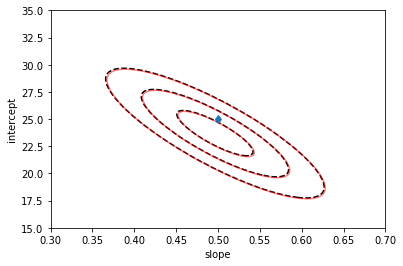

In [55]:
cutoffs1, cutoffs2 = contour_levels(P1), contour_levels(P2)
plt.contour(X, Y, P1, cutoffs1, colors='black', linestyles='--')
plt.contour(X, Y, P2, cutoffs1, colors='red', linestyles='-', alpha=0.5)
plt.plot(theta_true[1], theta_true[0], 'd')  # input value when generating data
plt.xlabel('slope')
plt.ylabel('intercept')

In the present case, you'll see that the form of the prior makes little difference on the results. This is often, but not always the case if you have enough data to constrain your model. Instead, if you have few data and/or large error bars, your results is more likely to be prior dependent which means that, if you do not have good data, you won't improve much your knowledge about the world you are probing with your data !  

## V. Bayesian Modeling with MCMC

See [Bayes_MCMC.ipynb](Bayes_MCMC.ipynb)

## XX References:

**Chapter 5** (5.1, 5.2, 5.3, 5.8) of the book <a class="anchor" id="book"></a> *Statistics, data mining and Machine learning in astronomy* by Z. Ivezic et al. in Princeton Series in Modern Astronomy. 

- This notebook includes a large fraction of the material that J. Vander Plas gave during the "Bayesian Methods in Astronomy workshop", presented at the 227th meeting of the American Astronomical Society. The full repository with that material can be found on GitHub: http://github.com/jakevdp/AAS227Workshop

- More insights on the differences between frequentist and Bayesian approaches: see [J. VanderPlass blog posts](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) 

- Jayes: [*Probability Theory: The Logic of Science*](http://bayes.wustl.edu/etj/prob/book.pdf).

- For some approachable reading on frequentist vs. Bayesian uncertainties, I'd suggest [The Fallacy of Placing Confidence in Confidence Intervals](https://learnbayes.org/papers/confidenceIntervalsFallacy/), as well as Jake VanderPlast blog post on the topic, [Confidence, Credibility, and why Frequentism and Science do not Mix](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/).

- Foreman-Mackey et al. 2012 [*EMCEE, the MCMC hammer*](https://arxiv.org/abs/1202.3665) ; see also http://dan.iel.fm/emcee/current/

- About the variety of approaches to MCMC: Allison and Dunkley 2013: [Comparison of sampling techniques for Bayesian parameter estimation](https://arxiv.org/abs/1308.2675). See also [How to Be a Bayesian in Python](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/). 

- Andreon 2011 [Understanding better (some) astronomical data using Bayesian methods](https://arxiv.org/abs/1112.3652)